# Turning Fitness Data Into Sound #

In this notebook, we use Python to create soundwaves from positional data recorded while running. The data was recorded using an Apple Watch, and the files generated from this code are intended for use in wavetable synthesizers (Vital is the best and free).

We also do some exploratory analysis of the Philadelphia Marathon to verify that our code functions as intended.

## Part 1: Data Extraction and Manipulation ##

### Import libraries and establish file location


We are using the gpxpy library to work with the .gpx files extracted from the Apple Health app. We are also using the osc_gen library to turn our data into waveforms and .wav files.

In [1]:
# importing necessary libraries
import os
import gpxpy
import gpxpy.gpx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from osc_gen import sig
from osc_gen import wavetable
from osc_gen import dsp
from osc_gen import visualize

In [43]:
# establish location for .gpx files exported from Apple Health App
location = '/Users/kevinstabinski/Dropbox/YouTube/Turning Fitness Data Into Sound/data/workout-routes'


# create list of runs
runs = os.listdir(location)


pd.DataFrame(runs)

,0
0,route_2023-02-22_4.55pm.gpx
1,route_2023-06-01_9.18am.gpx
2,route_2024-02-29_7.24pm.gpx
3,route_2023-03-13_4.30pm.gpx
4,route_2023-02-16_6.08pm.gpx
...,...
279,route_2023-04-11_5.43pm.gpx
280,route_2023-08-25_10.00am.gpx
281,route_2023-01-10_5.21pm.gpx
282,route_2023-01-03_6.12pm.gpx


### Define function to transform data into waveforms


There are 3 key considerations for this transformation:

- We want to preserve the shape of the curves, but the data must be condensed/stretched to be of length 2048: the length of a frame within Vital (wavetable synthesizer) is 2048 samples. 
    
- Soundwaves peak between -1 and 1, so we need to compress the data to be within this range. 

- If the average value of a waveform is not equal to 0, it introduces something known as 'DC Offset': it is an extremely undesirable characteristic and can cause various problems when mixing.

We will define a function to condense/stretch the data using linearly interpolation, so that we preserve the integrity of the curve. Further, we will subtract the set by its mean value to have it centered on 0. Finally, we will divide the set by its maximum absolute value so that it peaks between -1 and 1.

In [4]:
# defining function to compress/stretch data to be of length 2048, peak between -1 and 1, and have mean 0
def wav_transform(arr, numSamples=2048):

    transform = np.interp(np.linspace(0, len(arr), numSamples), np.arange(len(arr)), arr)
    transform -= np.mean(transform)
    transform /= np.max(abs(transform))
   
    return transform


### Iterate function for all runs and export to .wav files

For each run, we will use the gpxpy library to extract the elevation, longitude, and latitude curves. Then, we will use our function to standardize each curve into waveforms. Finally, we will employ the osc_gen library to store them into wavetables and export them as .wav files.

In [22]:
# iterating through all runs to transform each run's elevation, longitude, and latitude curves
for run in runs:


    # file
    file = location + '/' + run


    # open gpx file
    gpx_file = open(file, 'r')


    # parse gpx file
    gpx = gpxpy.parse(gpx_file)


    # create lists for the variables
    elevation = []
    longitude = []
    latitude = []


    # append array with elevation,longitude,latitude from gpx file
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                # appending values within .gpx file
                elevation.append(point.elevation)
                longitude.append(point.longitude)
                latitude.append(point.latitude)


    # performing transformation on elevation, longitude, latitude
    wav_elevation = wav_transform(elevation)
    wav_longitude = wav_transform(longitude)
    wav_latitude = wav_transform(latitude)


    # creating objects from osc_gen library to make wavetables
    sg = sig.SigGen()
    wt = wavetable.WaveTable(16)


    # morph between longitude, elevation, latitude to give it a smooth feel
    wt.waves = sig.morph((wav_longitude, wav_elevation, wav_latitude), 16)


    #creating file naming convention
    wavname = 'kev_run_' + run.split('_')[1] + '.wav'


    #saving wavetable as .wav file
    wt.to_wav(wavname, samplerate=48000)

## Part 2: Data Analysis of Marathon ##

I also thought it would be fun to do some exploratory data analysis of one of my runs. It is also a good way to verify that the code preserves the integrity of the curves when transforming them into waveforms. 

### Establish file location and read files

In [45]:
# establish location for gpx files
marathon_location = '/Users/kevinstabinski/Dropbox/YouTube/Turning Fitness Data Into Sound/data/marathon data'


# marathon file
file = marathon_location + '/' + 'marathon_apple.gpx'
strava_file = marathon_location + '/' + 'marathon_strava.gpx'


# open gpx file
gpx_file = open(file, 'r')
gpx_strava_file = open(strava_file, 'r')


# parse gpx file
gpx = gpxpy.parse(gpx_file)
gpx_strava = gpxpy.parse(gpx_strava_file)
moving_data = gpx.get_moving_data(raw=True)


# create array for marathon data
marathon_data = pd.DataFrame()


# creating array for heart rate stored in strava file
strava_data = pd.DataFrame()

### Extract all necessary data from the files and store in a dataframe

In [46]:
# create lists for each of the data points in file / we want to track
elevation = []
longitude = []
latitude = []
distance = []
elevation_gain = []
elevation_loss = []
speed = []
speed_calc = []
apple_time = []
strava_time = []
course = []
hr = []


# creating variables to be used in the extraction of data
instant_speed = 0
total_distance = 0
total_elevation_gain = 0
total_elevation_loss = 0
prev_point = None


# append array with elevation, longitude,latitude, time, distance data
for track in gpx.tracks:
    for segment in track.segments:
        for point in segment.points:
            # appending values within .gpx file
            elevation.append(point.elevation)
            longitude.append(point.longitude)
            latitude.append(point.latitude)
            apple_time.append(point.time)
            distance.append(total_distance)
            elevation_gain.append(total_elevation_gain)
            elevation_loss.append(total_elevation_loss)
            for ext in point.extensions:
                if ext.tag == 'speed':
                    speed.append(float(ext.text))
                elif ext.tag == 'course':
                    course.append(float(ext.text))
                else:
                    pass
                
            # calculating distance / elevation gain
            if prev_point:
                dist_change = point.distance_2d(prev_point)
                instant_speed = dist_change
                total_distance += dist_change
                inc_gain = point.elevation - prev_point.elevation

                if(inc_gain > 0):
                    total_elevation_gain += inc_gain
                elif(inc_gain < 0):
                    total_elevation_loss += inc_gain
                else:
                    pass
            
            speed_calc.append(instant_speed)

            prev_point = point


# obtaining heart rate information from strava file
for track in gpx_strava.tracks:
    for segment in track.segments:
        for point in segment.points:
                strava_time.append(point.time)
                for ext in point.extensions:
                    for extchild in ext:
                        hr.append(int(extchild.text))

Store it in a dataframe to make it easier to work with.

In [47]:
# adding marathon_data to pandas dataframe
marathon_data['time (s)'] = apple_time
marathon_data['elevation (m)'] = elevation
marathon_data['longitude'] = longitude
marathon_data['latitude'] = latitude
marathon_data['speed (m/s)'] = speed
marathon_data['course (deg)'] = course
marathon_data['elevation_gain (m)'] = elevation_gain
marathon_data['elevation_loss (m)'] = elevation_loss
marathon_data['distance (m)'] = distance
marathon_data['calculated speed (m/s)'] = speed_calc


# adding strava data (they are different sizes)
strava_data['time (s)'] = strava_time
strava_data['hr (bpm)'] = hr
                

# merging on marathon_data table
marathon_data = pd.merge(
    left=marathon_data,
    right=strava_data,
    on='time (s)',
    how='left'
)


# filling missing values for heart rate
marathon_data = marathon_data.fillna(method='ffill')


marathon_data



,time (s),elevation (m),longitude,latitude,speed (m/s),course (deg),elevation_gain (m),elevation_loss (m),distance (m),calculated speed (m/s),hr (bpm)
0,2023-11-19 12:11:31+00:00,15.240107,-75.175784,39.961874,1.275676,133.615369,0.000000,0.000000,0.000000,0.000000,154.0
1,2023-11-19 12:11:32+00:00,15.282989,-75.175772,39.961865,1.338736,134.652498,0.000000,0.000000,0.000000,1.432509,154.0
2,2023-11-19 12:11:33+00:00,15.321839,-75.175759,39.961856,1.379728,139.129256,0.042882,0.000000,1.432509,1.494686,154.0
3,2023-11-19 12:11:34+00:00,15.358184,-75.175746,39.961846,1.532589,138.767620,0.081732,0.000000,2.927195,1.571475,154.0
4,2023-11-19 12:11:35+00:00,15.390464,-75.175733,39.961834,1.690834,139.373381,0.118077,0.000000,4.498670,1.736313,154.0
...,...,...,...,...,...,...,...,...,...,...,...
13271,2023-11-19 15:52:42+00:00,15.780647,-75.177425,39.963983,2.394726,151.867131,384.059611,-383.425637,42653.637528,2.526582,170.0
13272,2023-11-19 15:52:43+00:00,15.693433,-75.177414,39.963965,2.045138,155.973715,384.059611,-383.519071,42656.164110,2.212657,170.0
13273,2023-11-19 15:52:44+00:00,15.610767,-75.177405,39.963949,1.772839,158.428803,384.059611,-383.606285,42658.376767,1.939590,170.0
13274,2023-11-19 15:52:45+00:00,15.531001,-75.177398,39.963936,1.520079,160.013685,384.059611,-383.688951,42660.316356,1.565552,170.0


### Plot time series

Create ditance checkpoints and times to reach each checkpoint.

In [49]:
# creating distance checkpoints
marathon_distances = [0, 5000, 10000, 15000, 21098, 25000, 30000, 35000, 40000, 42195]
marathon_labels = ['Start', '5km', '10km', '15km', 'Half', '25km', '30km', '35km', '40km', 'Finish']


# creating array to calculate time to reach each checkpoint
marathon_times = []

for j in range(len(marathon_distances)):
    marathon_times.append(next(i for i,v in enumerate(distance) if v > marathon_distances[j]))

Create graph of elevation, longitude, and latitude curves. 




    (I know this is a lot, but I think it looks nice)

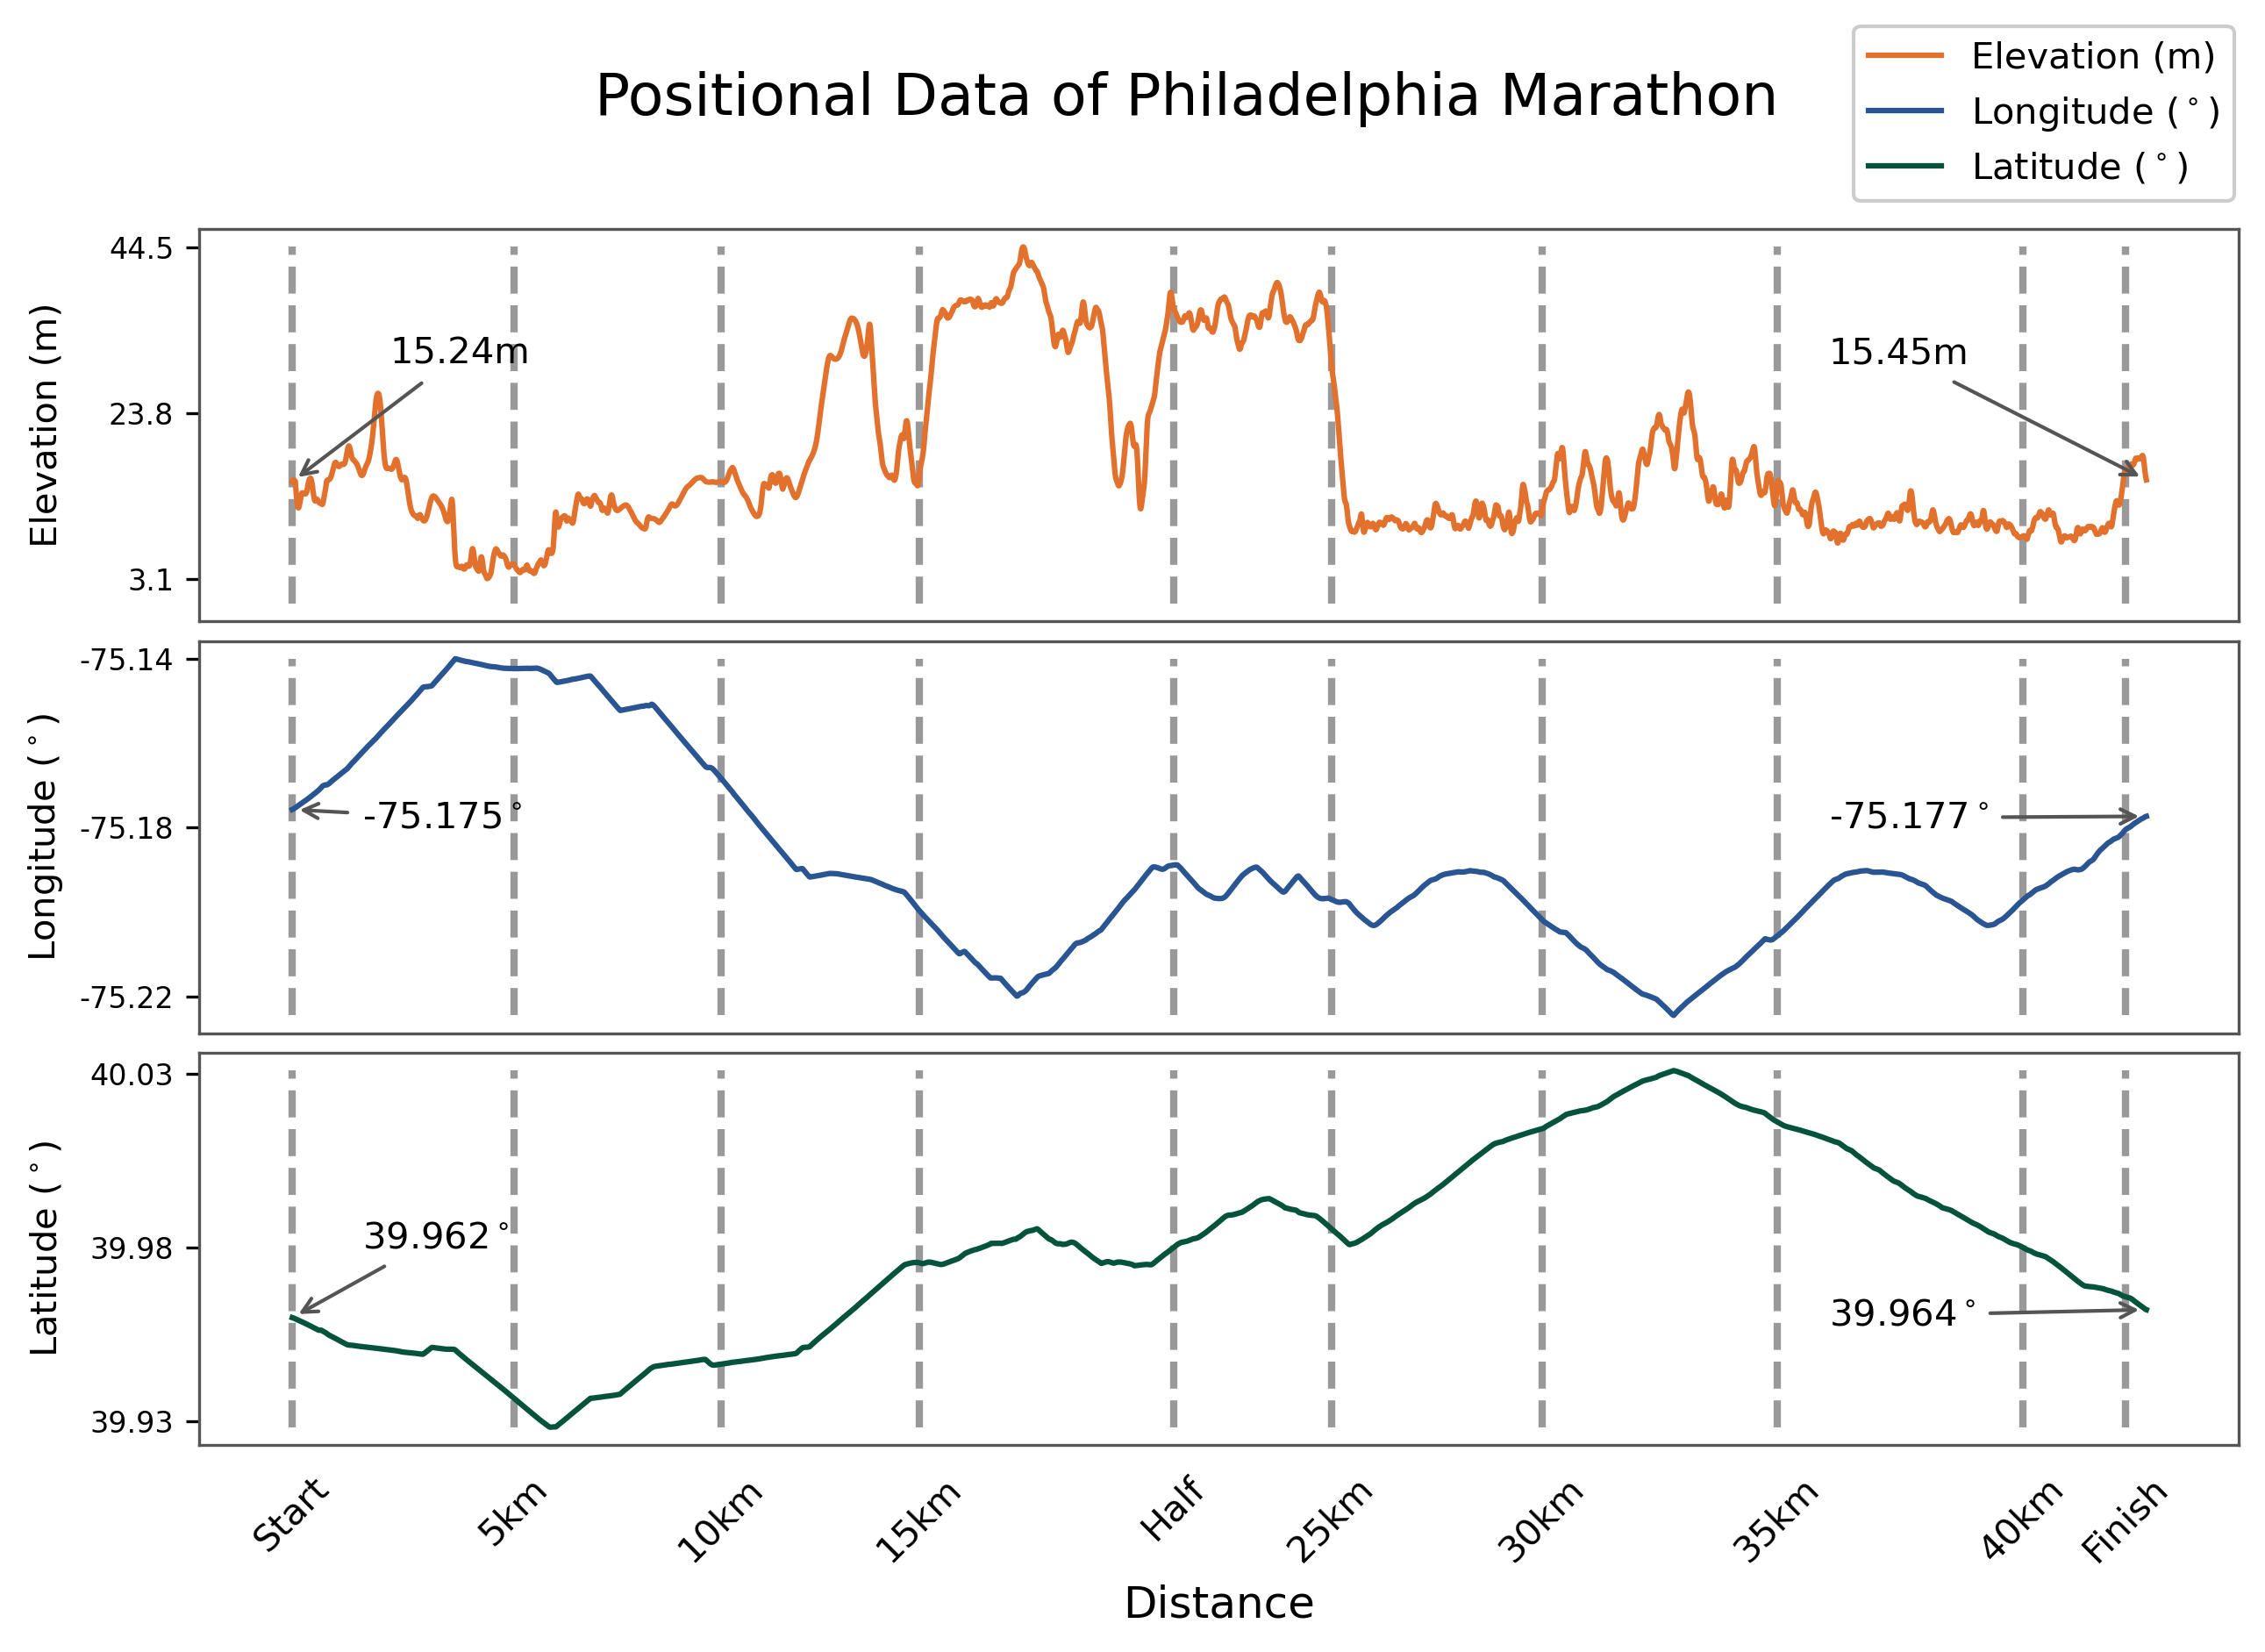

In [66]:
# choosing colors
color_one = '#E1712C'
color_two = '#295592'
color_three = '#05533D'


# set up figure with 3 rows
fig = plt.figure(dpi = 300, figsize= (10,6), facecolor = 'white')
fig.suptitle('Positional Data of Philadelphia Marathon', color = 'black', fontsize = 16)
gs = fig.add_gridspec(3, hspace=0.05)
axs = gs.subplots(sharex=True)

# plot elevation curve
axs[0].vlines(x=marathon_times, ymin = 0, ymax = np.max(elevation) ,colors='black', ls='--', lw=2, label= 'Checkpoints', alpha = 0.4)
elevation_handle, = axs[0].plot(marathon_data.index,marathon_data['elevation (m)'], label = 'Elevation (m)', alpha = 1, color=color_one)
axs[0].set_facecolor('white')
axs[0].grid(False)
axs[0].set_ylabel('Elevation (m)', color = 'black', fontsize = 10, rotation = 90)
axs[0].set_yticks(ticks = [3.1,23.8, 44.5], labels = [3.1,23.8,44.5], color = 'black', fontsize = 8)
axs[0].tick_params(axis = 'y', colors='black')
axs[0].annotate("15.24m",
            xy=(0, marathon_data['elevation (m)'][0]), xycoords='data',
            xytext=(700, 30), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )
axs[0].annotate("15.45m",
            xy=(np.max(marathon_data.index), marathon_data['elevation (m)'][np.max(marathon_data.index)]), xycoords='data',
            xytext=(11000, 30), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )


# plot longitude curve
axs[1].vlines(x=marathon_times, ymin = np.min(longitude), ymax = np.max(longitude) ,colors='black', ls='--', lw=2, label= 'Checkpoints', alpha = 0.4)
longitude_handle, = axs[1].plot(marathon_data.index,marathon_data['longitude'], label = 'Longitude $^/circ$', alpha = 1, color=color_two)
axs[1].set_facecolor('white')
axs[1].grid(False)
axs[1].set_ylabel('Longitude ($^\circ$)', color = 'black', fontsize = 10, rotation = 90)
axs[1].set_yticks(ticks = [-75.22,-75.18,-75.14], labels = [-75.22,-75.18,-75.14], color = 'black', fontsize = 8)
axs[1].tick_params(axis = 'y', colors='black')
axs[1].annotate("-75.175$^\circ$",
            xy=(0, marathon_data['longitude'][0]), xycoords='data',
            xytext=(500, -75.18), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )
axs[1].annotate("-75.177$^\circ$",
            xy=(np.max(marathon_data.index), marathon_data['longitude'][np.max(marathon_data.index)]), xycoords='data',
            xytext=(11000, -75.18), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )


# plot latitude curve
axs[2].vlines(x=marathon_times, ymin = np.min(latitude), ymax = np.max(latitude) ,colors='black', ls='--', lw=2, label= 'Checkpoints', alpha = 0.4)
latitude_handle, =axs[2].plot(marathon_data.index,marathon_data['latitude'], label = 'Latitude $^/circ$', alpha = 1, color=color_three)
axs[2].set_facecolor('white')
axs[2].grid(False)
axs[2].set_ylabel('Latitude ($^\circ$)', color = 'black', fontsize = 10, rotation = 90)
axs[2].set_yticks(ticks = [39.935,39.98,40.025], labels = [39.93,39.98,40.03], color = 'black', fontsize = 8)
axs[2].set_xlabel('Distance', color = 'black', fontsize = 12)
axs[2].set_xticks(ticks = marathon_times, labels = marathon_labels, color = 'black', fontsize = 10, rotation = 45)
axs[2].tick_params(axis = 'y', colors='black')
axs[2].annotate("39.962$^\circ$",
            xy=(0, marathon_data['latitude'][0]), xycoords='data',
            xytext=(500, 39.98), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )
axs[2].annotate("39.964$^\circ$",
            xy=(np.max(marathon_data.index), marathon_data['latitude'][np.max(marathon_data.index)]), xycoords='data',
            xytext=(11000, 39.96), textcoords='data', color = 'black',
            arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc"),
            )

# set up legend
handles = [elevation_handle, longitude_handle, latitude_handle]

fig.legend(handles = handles, labels = ['Elevation (m)', 'Longitude ($^\circ$)', 'Latitude ($^\circ$)', 'Checkpoints'], 
           frameon = True, fontsize = 10, facecolor = 'white', labelcolor = 'black', framealpha = 1, bbox_to_anchor = (.905,1.02))


# show plot
fig.align_labels()
plt.show()

### Transform elevation, longitude, and latitude curves

In [67]:
# transform each curve
wav_elevation = wav_transform(elevation)
wav_longitude = wav_transform(longitude)
wav_latitude = wav_transform(latitude)


# store them in a dataframe
wav_data = pd.DataFrame()
wav_data['elevation'] = wav_elevation
wav_data['longitude'] = wav_longitude
wav_data['latitude'] = wav_latitude


# confirm length 2048, peaks between -1 and 1, and has mean 0
length = len(wav_data)
peak = abs(wav_data).max()
mean = wav_data.mean()

length, peak, mean

(2048,
 elevation    1.0
 longitude    1.0
 latitude     1.0
 dtype: float64,
 elevation   -1.110223e-16
 longitude    1.427747e-13
 latitude     6.195044e-14
 dtype: float64)

### Plot waveforms

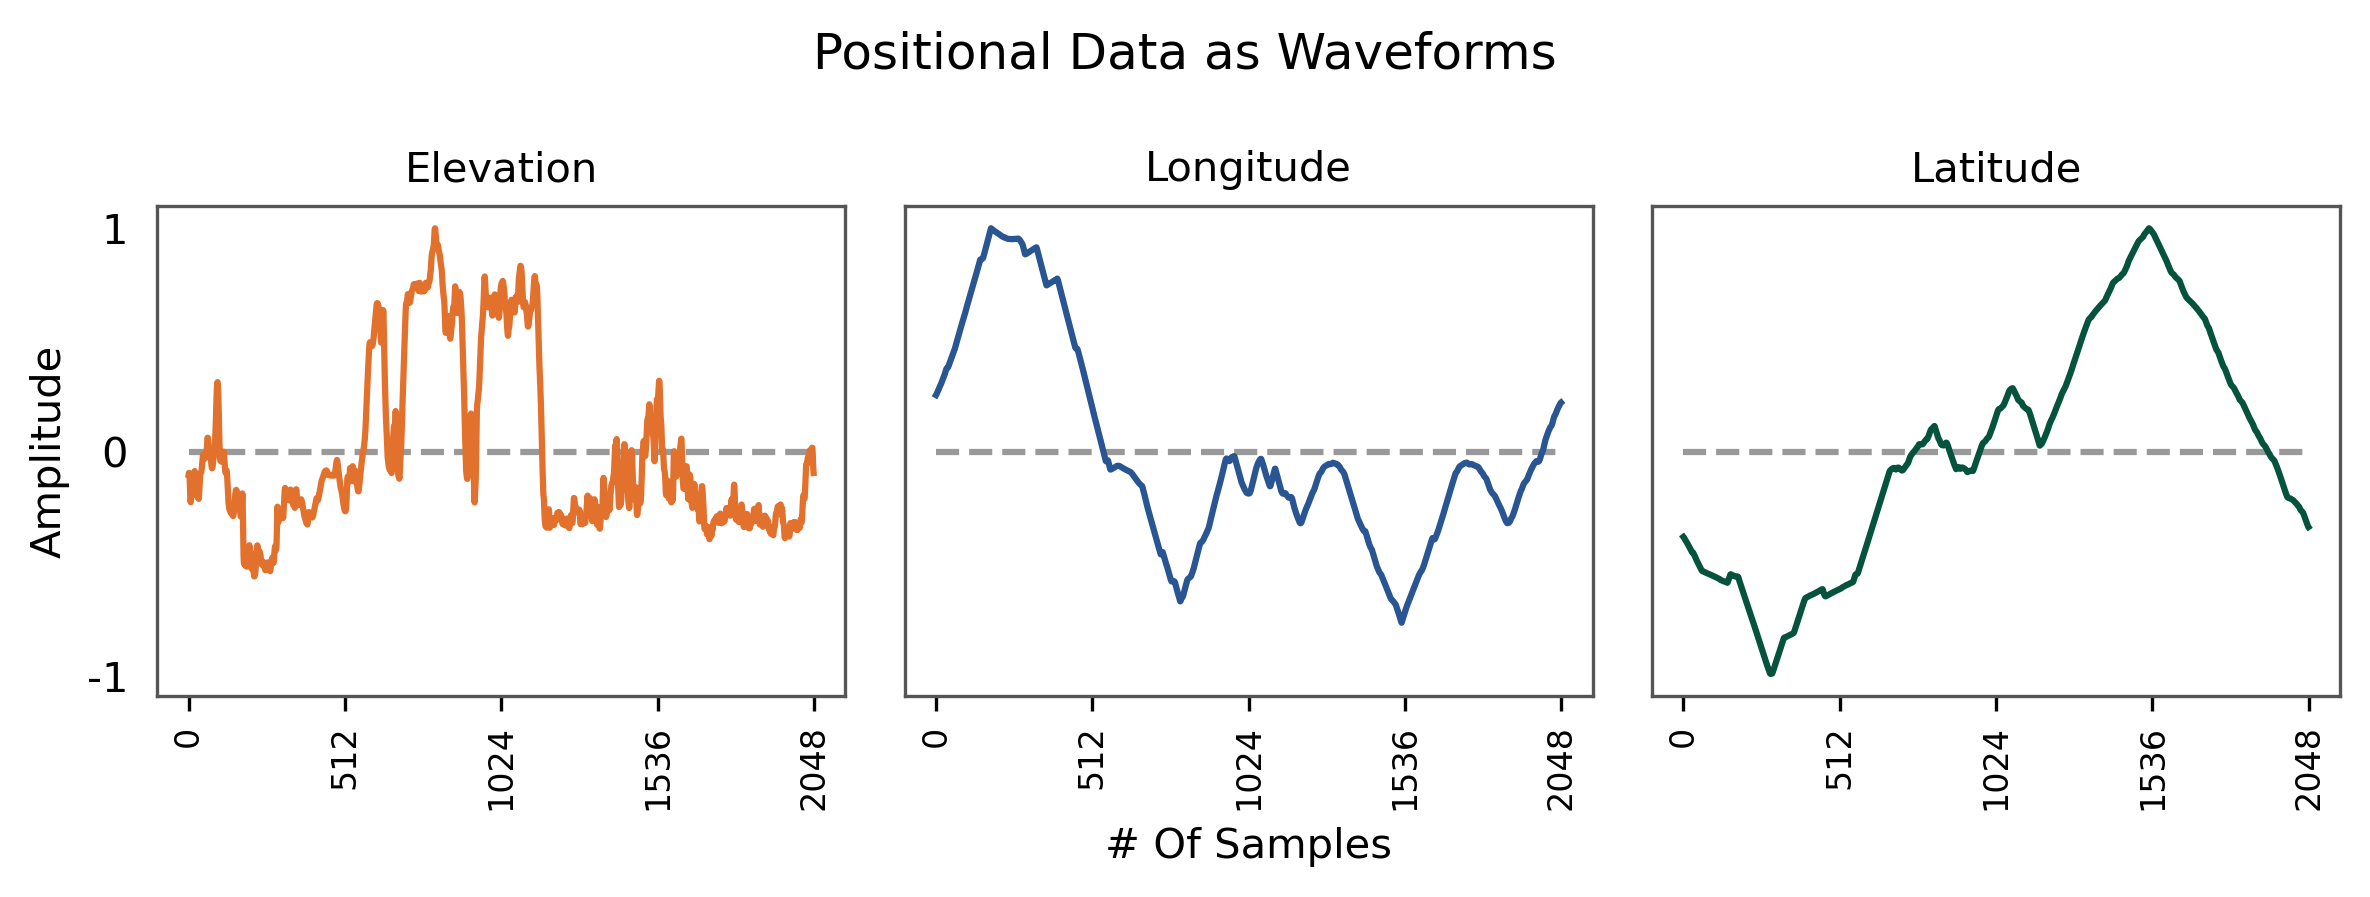

In [68]:
# set up figure with 3 columns
fig = plt.figure(dpi = 300, figsize= (8,3), facecolor = 'white')
fig.suptitle('Positional Data as Waveforms', color = 'black')
gs = fig.add_gridspec(1,3)
axs = gs.subplots(sharex=True,sharey=True)


# plot elevation
axs[0].hlines(xmin = 0, xmax = 2048, y = 0, color = 'black', ls= '--', alpha = 0.4)
elevation_wave, = axs[0].plot(wav_data.index,wav_data['elevation'], label = 'Elevation', alpha = 1, color=color_one)
axs[0].set_facecolor('white')
axs[0].set_yticks(ticks = [-1,0,1], labels = [-1,0,1], color = 'black', fontsize = 10)
axs[0].set_ylabel('Amplitude', color = 'black', fontsize = 10)
axs[0].set_xticks(ticks = [0,512,1024,1536,2048], labels = [0,512,1024,1536,2048], color = 'black', rotation = 90, fontsize = 8)
axs[0].tick_params(axis = 'x', colors = 'black')
axs[0].set_title('Elevation', color = 'black', fontsize = 10)


# plot longitude
axs[1].hlines(xmin = 0, xmax = 2048, y = 0, color = 'black', ls= '--', alpha = 0.4)
longitude_wave, = axs[1].plot(wav_data.index,wav_data['longitude'], label = 'Longitude', alpha = 1, color=color_two)
axs[1].set_facecolor('white')
axs[1].set_yticks(ticks = [-1,0,1], labels = [-1,0,1], color = 'black', fontsize = 10)
axs[1].set_xticks(ticks = [0,512,1024,1536,2048], labels = [0,512,1024,1536,2048], color = 'black', rotation = 90, fontsize = 8)
axs[1].tick_params(axis = 'x', colors = 'black')
axs[1].set_xlabel('# Of Samples', color = 'black', fontsize = 10)
axs[1].set_title('Longitude', color = 'black', fontsize = 10)


# plot latitude
axs[2].hlines(xmin = 0, xmax = 2048, y = 0, color = 'black', ls= '--', alpha = 0.4)
latitude_wave, = axs[2].plot(wav_data.index,wav_data['latitude'], label = 'Latitude', alpha = 1, color=color_three)
axs[2].set_facecolor('white')
axs[2].set_yticks(ticks = [-1,0,1], labels = [-1,0,1], color = 'black', fontsize = 10)
axs[2].set_xticks(ticks = [0,512,1024,1536,2048], labels = [0,512,1024,1536,2048], color = 'black', rotation = 90, fontsize = 8)
axs[2].tick_params(axis = 'x', colors = 'black')
axs[2].set_title('Latitude', color = 'black', fontsize = 10)


# show plot
fig.align_labels()
fig.tight_layout()
plt.show()